In [34]:
from __future__ import division

import numpy as np
np.random.seed(0)

import mltools as ml
import sys
sys.path.append('code')

import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
plt.set_cmap('jet');
%matplotlib inline
import warnings
warnings.filterwarnings('ignore'); # for deprecated matplotlib functions

In [35]:
X = np.genfromtxt('X_train.txt', delimiter = ',')
Y = np.genfromtxt('Y_train.txt', delimiter = ',')
Xte = np.genfromtxt('X_test.txt', delimiter = ',')
X, Y = ml.shuffleData(X,Y)

Xreal = X[:,0:41]
Xdiscrete = X[:, 41:69]
Xbinary = X[:, 69:]


In [36]:
Xtr,Xva,Ytr,Yva = ml.splitData(X, Y, 0.8) #Split data into 80/20 (Training 80, validation 20)
Xtr,param=ml.transforms.rescale(Xtr)
Xva,_=ml.transforms.rescale(Xva,param)
Xte,_=ml.transforms.rescale(Xte,param)
#X,_ = ml.transforms.rescale(X, param)       #?????????????


In [155]:
#Test maxDepth
err_tr = np.zeros(16)
err_va = np.zeros(16)

for i in range(16):
    new_learner = ml.dtree.treeClassify(Xtr, Ytr, maxDepth = i)
    
    err_tr[i] = new_learner.err(Xtr, Ytr)
    err_va[i] = new_learner.err(Xva, Yva)
    
plt.plot(err_tr, '-r')
plt.plot(err_va, '-g')
plt.xlabel("maxDepth")
plt.ylabel("error rate")
plt.legend(['Training error', 'Validation error'])
plt.show()

#maxDepth of 6 seems to be the best one.

KeyboardInterrupt: 

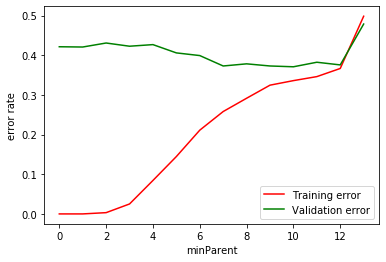

In [90]:
#Test minParent
min_prt = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

err_tr4 = np.zeros(14)
err_va4 = np.zeros(14)

for i in range(0,14):
    learner_4 = ml.dtree.treeClassify(Xtr, Ytr, maxDepth = 50, minParent = 2**i)
    err_tr4[i] = learner_4.err(Xtr, Ytr)
    err_va4[i] = learner_4.err(Xva, Yva)
    
plt.plot(err_tr4, '-r')
plt.plot(err_va4, '-g')
plt.xlabel("minParent")
plt.ylabel("error rate")

plt.legend(['Training error', 'Validation error'])
plt.show()

#minParent =8 is the best.

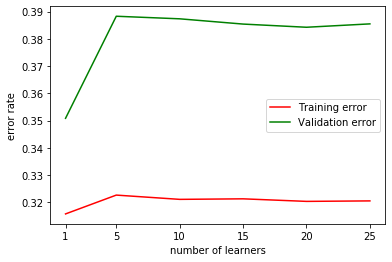

In [299]:
err_tr3 = np.zeros(25)
err_va3 = np.zeros(25)

classifiers123 = [None] * 25
for i in range(0, 25):
    Xi, Yi = ml.bootstrapData(Xtr, Ytr)
    rf_learner = ml.dtree.treeClassify(Xi, Yi, maxDepth = 50, minLeaf = 4, nFeatures = 60, minParent = 2**8)
    classifiers123[i] = rf_learner
    
    err_tr3[i] = rf_learner.err(Xtr, Ytr)
    err_va3[i] = rf_learner.err(Xva, Yva)
    
num_learners = [1,5,10,15,20,25]

tr_mean = np.zeros(6)
va_mean = np.zeros(6)

for i, v in enumerate([1,5,10,15,20,25]):
    #print(i, v)
    tr_mean[i] = np.mean(err_tr3[:v])
    va_mean[i] = np.mean(err_va3[:v])
    
   
    
plt.plot(num_learners, tr_mean, '-r')
plt.plot(num_learners, va_mean, '-g')
plt.xticks(num_learners)
plt.xlabel("number of learners")
plt.ylabel("error rate")

plt.legend(['Training error', 'Validation error'])
plt.show()

# Random Forests

In [39]:
nEnsembles = 25
classifiers = [None] * nEnsembles
tot_auc = 0
tr_auc = 0

for i in range(nEnsembles):
    Xi, Yi = ml.bootstrapData(Xtr, Ytr)
    rf_learner = ml.dtree.treeClassify(Xi, Yi, maxDepth = 50, minLeaf = 4, nFeatures = 60, minParent = 2**8)
    classifiers[i] = rf_learner
    
    tot_auc += rf_learner.auc(Xva, Yva)
    tr_auc += rf_learner.auc(Xtr, Ytr)


#toKaggle('Y_submit1.txt', pred)
tot_auc = tot_auc / nEnsembles
tr_auc = tr_auc / nEnsembles
print("vali_auc: ", tot_auc)
print("tr_auc: ", tr_auc)

vali_auc:  0.6885476650026122
tr_auc:  0.7513223562354737


50 4 60 8
maxdepth minleaf nfeature minParent     auc                          auc va vs tr
   /50      4        60       8       =  0.697814583711228               0.6976  vs 0.75???
   50       4        60       9                                          0.7108194 vs 0.7692198
   50       4        60       10                                         0.7031110 vs 0.7474864067
   50       4        50       9                                          0.6953 vs 0.7254'
   
   
   /50      4        80       8       =  0.6974959550154183
   70     4        80        6       =  0.7676                           0.667 vs 0.804
   50      4        80       7       =  0.784694503899873
   /50      4        60       6       = 0.657056                         0.662 vs 0.804
   /50      4        80       6       =  0.7680406729185562              0.665 vs. 0.807
   50      6        80       6       =  0.8115840014511155
   50      5        80       6       =  0.8100741157264649

In [49]:
pred = []
pred2 = []
pred3 = []

for i in range(len(classifiers)):
    predictions = classifiers[i].predictSoft(Xte)[:,1]
    pred.append(predictions)
    
    predictions2 = classifiers[i].predictSoft(Xva)[:,1]
    pred2.append(predictions2)
    
    predictions3 = classifiers[i].predictSoft(Xtr)[:,1]
    pred3.append(predictions3)
    
pred = np.asarray(pred)
pred2 = np.asarray(pred2)
pred3 = np.asarray(pred3)

output = np.zeros(7422)
for i in range(0,7422):
    tot = 0
    for x in pred:
        tot += x[i]
    output[i] = tot/nEnsembles
    
output1_val = np.zeros(Xva.shape[0])
for i in range(Xva.shape[0]):
    tot2 = 0
    for x in pred2:
        tot2 += x[i]
    output1_val[i] = tot2/nEnsembles
    
output2_tr = np.zeros(Xtr.shape[0])
for i in range(Xtr.shape[0]):
    tot3 = 0
    for x in pred3:
        tot3 += x[i]
    output2_tr[i] = tot3/nEnsembles

toKaggle('Y_submit1.txt', output)
toKaggle('Vali1.txt', output1_val)
toKaggle('Train1.txt', output2_tr)

In [252]:
#Yte1 = np.vstack((np.arange(Xte.shape[0]), output)).T
#np.savetxt('Y_submit1.txt', Yte1,'%d,%.2f', header = 'Id,Predicted', comments = '', delimiter = ',')
print(Xte.shape)
print(Xva.shape)

(7422, 107)
(1485, 107)


# RANDOM FORESTS WITH 3 DIFFERENT X SETS (Version 3)

In [67]:
Xreal_te = Xte[:,0:41]
Xdiscrete_te = Xte[:, 41:69]
Xbinary_te = Xte[:, 69:]

Xreal_tr,Xreal_va,Yreal_tr,Yreal_va = ml.splitData(Xreal, Y, 0.8) #Split data into 80/20 (Training 80, validation 20)
Xreal_tr,param=ml.transforms.rescale(Xreal_tr)
Xreal_va,_=ml.transforms.rescale(Xreal_va,param)
Xreal_te,_=ml.transforms.rescale(Xreal_te,param)



#XREAL
nEnsembles = 20
classifiers = [None] * nEnsembles

tot_auc1 = 0
tr_auc1 = 0

for i in range(nEnsembles):
    Xi, Yi = ml.bootstrapData(Xreal_tr, Yreal_tr)
    rf_learner = ml.dtree.treeClassify(Xi, Yi, maxDepth = 50, minLeaf = 4, nFeatures = 60, minParent = 2**8)
    classifiers[i] = rf_learner
    
    tot_auc1 += rf_learner.auc(Xreal_va, Yreal_va)
    tr_auc1 += rf_learner.auc(Xreal_tr, Yreal_tr)
    
tot_auc1 = tot_auc1 / nEnsembles
tr_auc1 = tr_auc1 / nEnsembles

In [68]:
pred = []

for i in range(len(classifiers)):
    predictions = classifiers[i].predictSoft(Xreal_te)[:,1]
    pred.append(predictions)

pred = np.asarray(pred)

output = np.zeros(7422)
for i in range(0,7422):
    tot = 0
    for x in pred:
        tot += x[i]
    output[i] = tot/nEnsembles
    


In [69]:
Xdiscrete_tr,Xdiscrete_va,Ydiscrete_tr,Ydiscrete_va = ml.splitData(Xdiscrete, Y, 0.8) #Split data into 80/20 (Training 80, validation 20)
Xdiscrete_tr,param=ml.transforms.rescale(Xdiscrete_tr)
Xdiscrete_va,_=ml.transforms.rescale(Xdiscrete_va,param)
Xdiscrete_te,_=ml.transforms.rescale(Xdiscrete_te,param)
#XDISCRETE

nEnsembles = 20
classifiers = [None] * nEnsembles

tot_auc2 = 0
tr_auc2 = 0

for i in range(nEnsembles):
    Xi, Yi = ml.bootstrapData(Xdiscrete_tr, Ydiscrete_tr)
    rf_learner = ml.dtree.treeClassify(Xi, Yi, maxDepth = 50, minLeaf = 4, nFeatures = 60, minParent = 2**8)
    classifiers[i] = rf_learner
    
    tot_auc2 += rf_learner.auc(Xdiscrete_va, Ydiscrete_va)
    tr_auc2 += rf_learner.auc(Xdiscrete_tr, Ydiscrete_tr)
    
tot_auc2 = tot_auc2 / nEnsembles
tr_auc2 = tr_auc2 / nEnsembles

In [70]:
pred = []

for i in range(len(classifiers)):
    predictions = classifiers[i].predictSoft(Xdiscrete_te)[:,1]
    pred.append(predictions)

pred = np.asarray(pred)

output2 = np.zeros(7422)
for i in range(0,7422):
    tot = 0
    for x in pred:
        tot += x[i]
    output2[i] = tot/nEnsembles

In [71]:
Xbinary_tr,Xbinary_va,Ybinary_tr,Ybinary_va = ml.splitData(Xbinary, Y, 0.8) #Split data into 80/20 (Training 80, validation 20)
Xbinary_tr,param=ml.transforms.rescale(Xbinary_tr)
Xbinary_va,_=ml.transforms.rescale(Xbinary_va,param)
Xbinary_te,_=ml.transforms.rescale(Xbinary_te,param)

#XBINARY
nEnsembles = 20
classifiers = [None] * nEnsembles

tot_auc3 = 0
tr_auc3 = 0

for i in range(nEnsembles):
    Xi, Yi = ml.bootstrapData(Xbinary_tr, Ybinary_tr)
    rf_learner = ml.dtree.treeClassify(Xi, Yi, maxDepth = 50, minLeaf = 4, nFeatures = 60, minParent = 2**8)
    classifiers[i] = rf_learner
    
    tot_auc3 += rf_learner.auc(Xbinary_va, Ybinary_va)
    tr_auc3 += rf_learner.auc(Xbinary_tr, Ybinary_tr)
    
tot_auc3 = tot_auc3 / nEnsembles
tr_auc3 = tr_auc3 / nEnsembles


In [72]:
pred = []

for i in range(len(classifiers)):
    predictions = classifiers[i].predictSoft(Xbinary_te)[:,1]
    pred.append(predictions)

pred = np.asarray(pred)

output3 = np.zeros(7422)
for i in range(0,7422):
    tot = 0
    for x in pred:
        tot += x[i]
    output3[i] = tot/nEnsembles

In [73]:
final_output = np.zeros(7422)
for i in range(0,7422):
    final_output[i] = (output[i] + output2[i] + output3[i])/3

final_auc_tr = (tr_auc1 + tr_auc2 + tr_auc3) /3
final_auc_va = (tot_auc1 + tot_auc2 + tot_auc3) /3

print("Training auc:", final_auc_tr)
print('Validation auc:', final_auc_va)

0.7396655332174924 0.676183915510536
Training auc: 0.6494941666321564
Validation auc: 0.5930021580706643


In [75]:
toKaggle('Y_submit_rf_version3.txt', final_output)
#toKaggle('Vali1.txt', output1_val)

# Neural Network

In [106]:
nHidden = 700
nnet = ml.nnet.nnetClassify()
nnet.setActivation('logistic')
nnet.init_weights([Xtr.shape[1], nHidden, 2], 'random', addZeroFeature(Xtr, 85), Ytr)
nnet.train(Xtr, Ytr, stepsize=0.05, stopIter=10000)
print(nnet.auc(Xva,Yva))
print(nnet.auc(Xtr,Ytr))


output2_va = nnet.predictSoft(Xva)
output2_te = nnet.predictSoft(Xte)
output2_tr = nnet.predictSoft(Xtr)

toKaggle('Vali2.txt', output2_va[:,1])
toKaggle('Y_submit2.txt', output2_te[:,1])
toKaggle('Train2.txt', output2_tr[:,1])

it 1 : Jsur = 0.5411796568867927, J01 = 0.4917480633209835
it 2 : Jsur = 0.49469986976992336, J01 = 0.42943752105085886
it 4 : Jsur = 0.46931476559956015, J01 = 0.3912091613337824
it 8 : Jsur = 0.4585391281005691, J01 = 0.3826204109127652
it 16 : Jsur = 0.45481808207474206, J01 = 0.38026271471876055
0.6385778864573054
0.6743949973932938


In [22]:
def toKaggle(filename,YeHat):
    fh=open(filename,'w')# open file for upload
    fh.write('ID,Predicted\n')# output header line
    for i,yi in enumerate(YeHat.ravel()):
        fh.write('{},{}\n'.format(i,yi))# output each prediction
    fh.close() 

# KNN

In [46]:
num_clusters = 10
ssd = np.inf

for i in range(10):
    Z1, c1, ssd1 = ml.cluster.kmeans(Xtr, K = num_clusters, init = 'k++')
    if ssd1 < ssd:
        Z, c, ssd = Z1, c1, ssd1

KNN = ml.knn.knnClassify(c, np.array(range(num_clusters)), 1)

In [51]:
XtC=ml.to1ofK(KNN.predict(Xtr),np.array(range(num_clusters)))
XvC=ml.to1ofK(KNN.predict(Xva),np.array(range(num_clusters)))
XeC=ml.to1ofK(KNN.predict(Xte),np.array(range(num_clusters)))

XtC2=np.einsum('ij,ik->ijk',XtC,Xtr).reshape((Xtr.shape[0],Xtr.shape[1]*num_clusters))
XvC2=np.einsum('ij,ik->ijk',XvC,Xva).reshape((Xva.shape[0],Xva.shape[1]*num_clusters))
XeC2=np.einsum('ij,ik->ijk',XeC,Xte).reshape((Xte.shape[0],Xte.shape[1]*num_clusters))

linc2=ml.linearC.linearClassify(XtC2,Ytr,initStep=.01,reg=1e-3,stopIter=300)
output3 = linc2.predictSoft(XeC2)
output3_val = linc2.predictSoft(XvC2)
output3_tr = linc2.predictSoft(XtC2)
print("Training auc:", linc2.auc(XtC2, Ytr))
print("Clustered LinClassify: Validation AUC ~",linc2.auc(XvC2,Yva))
toKaggle('Y_submit3.txt', output3[:,1])
toKaggle('Vali3.txt', output3_val[:,1])
toKaggle('Train3.txt', output3_tr[:,1])

Training auc: 0.7273005245748005
Clustered LinClassify: Validation AUC ~ 0.6242562547164335


the number of neighbors used: 1 -> 0.67297658
initstep = 0.1 -> 0.63
initstep = 0.05 -> 0.6390
reg 1e-3. deefault.
reg 1e-4 -> 0.6389

numclusters = 10 -> 0.663039258
numclusters = 20 -> 0.63783306

   # New KNN Clustering By Yulim

In [104]:
nClusters = 3
inits = ['k++', 'random', 'farthest']
sumD = np.inf

valErr_x = []
trainErr_x = []

for i in range(5):
    for j in inits:
        Zi, ci, sumDi = ml.cluster.kmeans(addSameFeature(Xtr, 80), K=nClusters, init=j)
        if sumDi < sumD:
            Z, C, sumD = Zi, ci, sumDi
            #Z: N x 1 array containing cluster numbers of data at indices X
            #C: K x M array of cluster centers
            #sumD: (scalar) sum of squared euclidean distances

#fig, ax = plt.subplots(1, 2, figsize=(20,8))
#ax[0].scatter(Xtr[:,0], Xtr[:,1], c=Ytr) #plots original data
#ax[1].scatter(Xtr[:,0], Xtr[:,1], c=Ytr) #plots the clustered data
#ax[1].scatter(C[:,0], C[:,0], s=500, marker='x', facecolor='black', lw=8)
#plt.show()
KNN = ml.knn.knnClassify(C, np.array(range(nClusters)), 1)

XtrC=ml.to1ofK(KNN.predict(Xtr),np.array(range(nClusters)))
XvaC=ml.to1ofK(KNN.predict(Xva),np.array(range(nClusters)))
XteC=ml.to1ofK(KNN.predict(Xte),np.array(range(nClusters)))

XtrC2=np.einsum('ij,ik->ijk',XtrC,Xtr).reshape((Xtr.shape[0],Xtr.shape[1]*nClusters))
XvaC2=np.einsum('ij,ik->ijk',XvaC,Xva).reshape((Xva.shape[0],Xva.shape[1]*nClusters))
XteC2=np.einsum('ij,ik->ijk',XteC,Xte).reshape((Xte.shape[0],Xte.shape[1]*nClusters))

KNNlinearClassifier = ml.linearC.linearClassify(XtrC2, Ytr, initStep=0.01, stopIter=30)
Pva3 = KNNlinearClassifier.predictSoft(XvaC2)
Pte3 = KNNlinearClassifier.predictSoft(XteC2)
Ptr3 = KNNlinearClassifier.predictSoft(XtrC2)

toKaggle('Y_submit3.txt', Pte3[:,1])
toKaggle('Vali3.txt', Pva3[:,1])
toKaggle('Train3.txt', Ptr3[:,1])

print("3: Clustered LinClassify: Validation AUC ~",KNNlinearClassifier.auc(XvaC2,Yva))
print("3: Clustered LinClassify: Training AUC ~",KNNlinearClassifier.auc(XtrC2,Ytr))


3: Clustered LinClassify: Validation AUC ~ 0.6214898850641435
3: Clustered LinClassify: Training AUC ~ 0.6737420444405112


In [103]:
def addZeroFeature(X, K):
    newX = X.copy()
    for i in range(X.shape[1]): #add zero features
        if i > K: 
            newX[:,i] = np.zeros(X[:,i].shape)
    return newX

def addSameFeature(X,K): # R
    newX = X.copy()
    for i in range(X.shape[1]):
        if i>K:
            newX[:,i] = np.random.randint(0,3, size=X[:,i].shape)
    return newX
def addZeroData(X, K):
    newX = X.copy()
    for i in range(X.shape[0]): # add zero dataset 
        if i > K:
            newX[i,:] = np.array(X[i,:].shape)
    return newX


# Gradient Boosting

In [303]:
def sigma(z):
    return np.exp(-z)/(1.+np.exp(-z))

va_pred = np.zeros(Xva.shape[0])
te_pred = np.zeros(Xte.shape[0])

va_result = np.zeros(Xva.shape[0])
te_result = np.zeros(Xte.shape[0])

nBags = 20

learners = [None] * nBags
alpha = 0.5

f = np.zeros(Ytr.shape)
for k in range(nBags):
    dY = 1.*Ytr - sigma(f)
    learners[k] = ml.dtree.treeRegress(Xtr, dY, maxDepth = 3, minParent = 2**12)
    f -= alpha * learners[k].predict(Xtr)
    va_pred += -alpha * learners[k].predict(Xva)
    te_pred += -alpha * learners[k].predict(Xte)
    
    va_result = sigma(va_pred)
    te_result = sigma(te_pred)

toKaggle('Y_submit4.txt', te_result)
toKaggle('Vali4.txt', va_result)




In [287]:
print(va_result)

[0.53931953 0.53931953 0.53931953 ... 0.53931953 0.22461685 0.73780271]


[0.59090909 0.16666667 0.59090909 ... 0.59090909 0.59090909 0.16666667]


In [107]:
va1 = np.genfromtxt('Vali1.txt',delimiter=',',skip_header=1)[:,1:2]
va2 = np.genfromtxt('Vali2.txt',delimiter=',',skip_header=1)[:,1:2]
va3 = np.genfromtxt('Vali3.txt',delimiter=',',skip_header=1)[:,1:2]
va4 = np.genfromtxt('Vali4.txt',delimiter=',', skip_header=1)[:,1:2]
stacked_vali = np.hstack((va1, va2, va3))#, va4))
stack_classifier = ml.linearC.linearClassify(stacked_vali, Yva, reg=1e-3)

tr1 = np.genfromtxt('Train1.txt',delimiter=',',skip_header=1)[:,1:2]
tr2 = np.genfromtxt('Train2.txt',delimiter=',',skip_header=1)[:,1:2]
tr3 = np.genfromtxt('Train3.txt',delimiter=',',skip_header=1)[:,1:2]
stacked_tr = np.hstack((tr1, tr2, tr3))#, va4))
stack_classifier_tr = ml.linearC.linearClassify(stacked_tr, Ytr, reg=1e-3)


print("Validation auc:", stack_classifier.auc(stacked_vali, Yva))
print("Training auc:",stack_classifier_tr.auc(stacked_tr, Ytr))
ys1 = np.genfromtxt('Y_submit1.txt',delimiter=',',skip_header=1)[:,1:2]
ys2 = np.genfromtxt('Y_submit2.txt',delimiter=',',skip_header=1)[:,1:2]
ys3 = np.genfromtxt('Y_submit3.txt',delimiter=',',skip_header=1)[:,1:2]
ys4 = np.genfromtxt('Y_submit4.txt',delimiter=',',skip_header=1)[:,1:2]
stacked = np.hstack((ys1, ys2, ys3))#, ys4))
predict_stacked = stack_classifier.predictSoft(stacked)
toKaggle('Stacked.txt', predict_stacked[:,1])

Validation auc: 0.7495537528298601
Training auc: 0.8610251758463001


In [ ]:
1,3 = 0.731649
1234 = 0.7331496
1234 = 0.73354693799 (numclusters = 20)
123 = 0.7493614674638648